# Sources
https://www.kaggle.com/code/rafjaa/dealing-with-very-small-datasets

https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/Basic%20SHAP%20Interaction%20Value%20Example%20in%20XGBoost.html

# Loading and Preprocessing Data


In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the dataset
df = pd.read_csv('aggregated_plants.csv')

# Dropping non-relevant columns
df = df.drop(columns=['Plant_Species', 'Reference', 'BitInterpretations'])

# Separating features and target
features = df.drop('Salmonella Typhimurium', axis=1)
target = df['Salmonella Typhimurium'] 

# Splitting the dataset into training and testing sets
X_train, X_test_unseen, y_train, y_test_unseen = train_test_split(features, target, test_size=0.2, random_state=42)


# Removing outliers

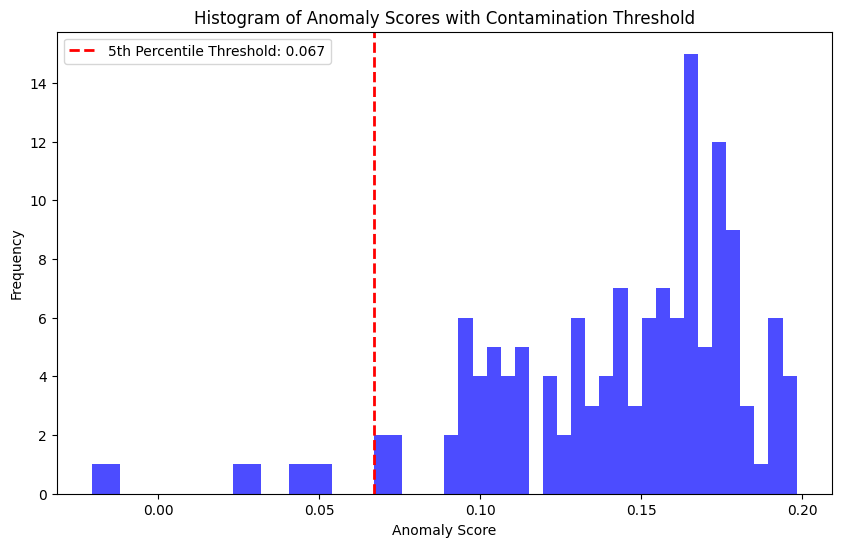

5th Percentile Contamination Threshold: 0.06695243525341885


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

# Fit the Isolation Forest model
iso_forest = IsolationForest(random_state=42)
iso_forest.fit(X_train)

# Compute the anomaly scores (the lower, the more abnormal)
scores = iso_forest.decision_function(X_train)

# Determine the contamination level based on the anomaly scores
contamination_level = np.percentile(scores, 5)

# Plot the histogram of anomaly scores with contamination threshold
plt.figure(figsize=(10, 6))
plt.hist(scores, bins=50, color='blue', alpha=0.7)
plt.axvline(x=contamination_level, color='red', linestyle='dashed', linewidth=2, 
            label=f'5th Percentile Threshold: {contamination_level:.3f}')
plt.title('Histogram of Anomaly Scores with Contamination Threshold')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
plt.legend()
plt.savefig('charts/anomaly_scores_histogram.png', dpi=300, bbox_inches='tight')
plt.show()

print("5th Percentile Contamination Threshold:", contamination_level)

# Identify and filter outliers
outliers = scores < contamination_level
X_train_filtered = X_train[~outliers]
y_train_filtered = y_train[~outliers]


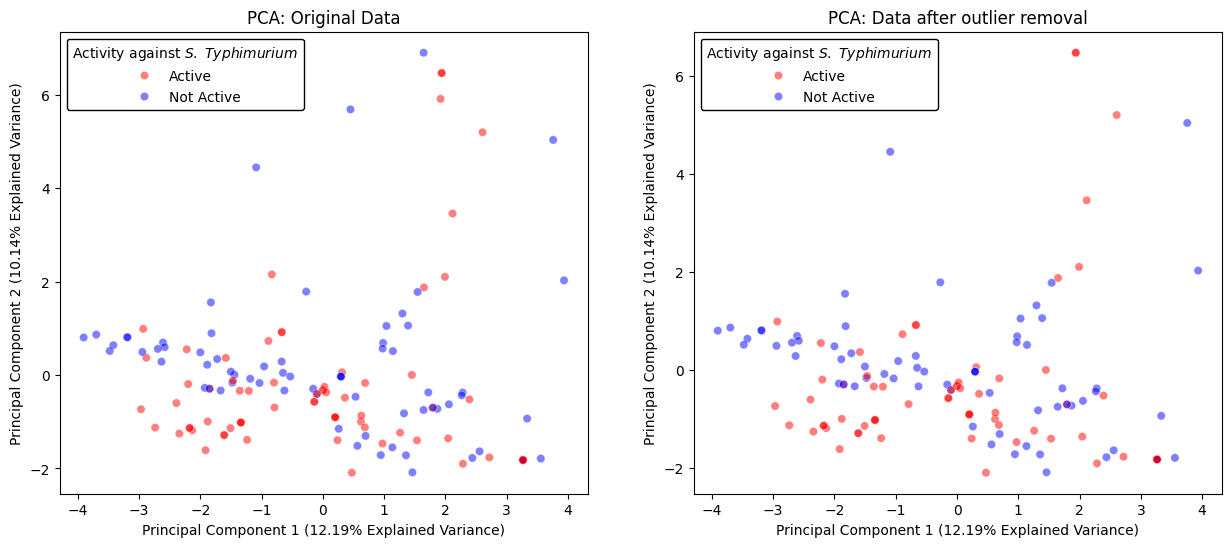

In [8]:
from sklearn.decomposition import PCA
import seaborn as sns

# Apply PCA for dimensionality reduction for visualization
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_train_filtered_pca = pca.transform(X_train_filtered)
pca_variance = pca.explained_variance_ratio_

# Mapping target values to 'Active' and 'Not Active'
activity_labels = y_train.map({1: 'Active', 0: 'Not Active'}).values
activity_labels_filtered = y_train_filtered.map({1: 'Active', 0: 'Not Active'}).values

# Plotting
plt.figure(figsize=(15, 6))

# Original Data
ax1 = plt.subplot(1, 2, 1)
sns.scatterplot(x=X_train_pca[:, 0], y=X_train_pca[:, 1], hue=activity_labels,
                alpha=0.5, palette={'Active': 'red', 'Not Active': 'blue'})
plt.title('PCA: Original Data')
plt.xlabel(f'Principal Component 1 ({pca_variance[0]:.2%} Explained Variance)')
plt.ylabel(f'Principal Component 2 ({pca_variance[1]:.2%} Explained Variance)')
legend = ax1.legend(title="Activity against $\it{S.\ Typhimurium}$", frameon=True, facecolor='white')
legend.get_frame().set_alpha(None)
legend.get_frame().set_edgecolor('black')

# Data After Outlier Removal
ax2 = plt.subplot(1, 2, 2)
sns.scatterplot(x=X_train_filtered_pca[:, 0], y=X_train_filtered_pca[:, 1], hue=activity_labels_filtered,
                alpha=0.5, palette={'Active': 'red', 'Not Active': 'blue'})
plt.title('PCA: Data after outlier removal')
plt.xlabel(f'Principal Component 1 ({pca_variance[0]:.2%} Explained Variance)')
plt.ylabel(f'Principal Component 2 ({pca_variance[1]:.2%} Explained Variance)')
legend = ax2.legend(title="Activity against $\it{S.\ Typhimurium}$", frameon=True, facecolor='white')
legend.get_frame().set_alpha(None)
legend.get_frame().set_edgecolor('black')

# Save the figure
plt.savefig('charts/outlier_detection_result.png', dpi=300, bbox_inches='tight')

plt.show()


# Determining the Number of Features with RFE and optimizing parameters with GridSearch 

In [9]:
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.feature_selection import RFE
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
import pandas as pd
import numpy as np


# Splitting the training dataset
X_train_grid, X_test_grid, y_train_grid, y_test_grid = train_test_split(
    X_train_filtered, y_train_filtered, test_size=0.2, random_state=42)

# Instantiate the XGBoost model
model = XGBClassifier(use_label_encoder=False, random_state=42, eval_metric='aucpr', n_jobs=-1)

# Define the parameter grid for the model
param_grid = {
    'n_estimators': [15, 20, 25],
    'max_depth': [2],
    'learning_rate': [0.4, 0.5, 0.6],
    'colsample_bytree': [0.4, 0.5],
    'reg_lambda': [0.4, 0.5, 0.6],
    'gamma': [0.1, 0.5, 1, 2],
    'subsample': [0.5, 0.7, 0.9]
}

# Initialize a dictionary to store the best score and the corresponding number of features
best_score = 0
best_num_features = 0
best_model = None
best_support = None

# Iterate over the range of features from 6 to 10
for num_features in range(6, 10):
    # Set up RFE with the current number of features
    rfe = RFE(estimator=model, n_features_to_select=num_features, step=1)
    rfe.fit(X_train_grid, y_train_grid)
    
    # Configure the base model for Grid Search
    base_model_params = {
        'use_label_encoder': False,
        'random_state': 42,
        'eval_metric': 'aucpr',
        'n_jobs': -1 
    }
    
    # Perform Grid Search to optimize the model with the selected features
    grid_search = GridSearchCV(estimator=XGBClassifier(**base_model_params),
                               param_grid=param_grid, scoring='roc_auc', cv=StratifiedKFold(5), n_jobs=-1)
    grid_search.fit(X_train_grid.iloc[:, rfe.support_], y_train_grid)

    # Check if the current model has a better score
    if grid_search.best_score_ > best_score:
        best_score = grid_search.best_score_
        best_num_features = num_features
        best_model = grid_search.best_estimator_
        best_support = rfe.support_

# Print the best configuration
print(f"Best number of features: {best_num_features}")
print("Best parameters found: ", best_model.get_params())
print("Best ROC AUC score on training set: ", best_score)

# Evaluate on the test set using the best model and feature set
X_test_selected = X_test_grid.iloc[:, best_support]
y_pred_proba = best_model.predict_proba(X_test_selected)[:, 1]
roc_auc = roc_auc_score(y_test_grid, y_pred_proba)

print(f"ROC AUC on test set: {roc_auc:.3f}")


Best number of features: 8
Best parameters found:  {'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.4, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': 'aucpr', 'feature_types': None, 'gamma': 0.5, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.5, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 2, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 25, 'n_jobs': -1, 'num_parallel_tree': None, 'random_state': 42, 'reg_alpha': None, 'reg_lambda': 0.4, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 0.9, 'tree_method': None, 'validate_parameters': None, 'verbosity': None, 'use_label_encoder': False}
Best ROC AUC score on training s

# PDP plots

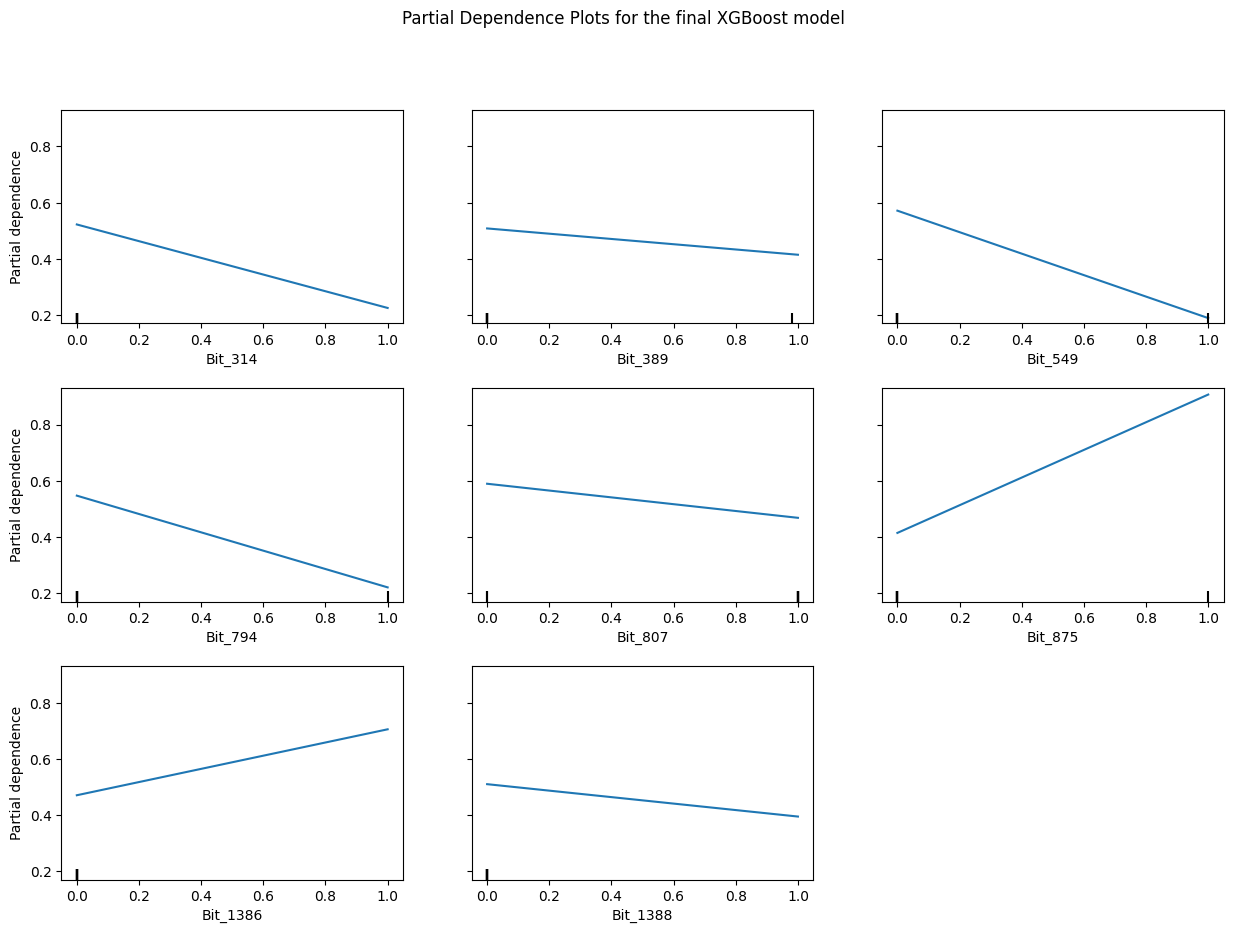

In [10]:
import os
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# Ensure the 'charts' directory exists
if not os.path.exists('charts'):
    os.makedirs('charts')


# Feature names for the selected features
feature_names = X_train_grid.columns[best_support]

# Plot Partial Dependence for each selected feature
fig, ax = plt.subplots(figsize=(15, 10))
display = PartialDependenceDisplay.from_estimator(
    best_model,
    X=X_train_grid.iloc[:, best_support],
    features=feature_names,
    kind='average',
    ax=ax,
    grid_resolution=20  # Adjust grid_resolution for finer plot resolution
)

# Enhancing plot aesthetics
display.figure_.suptitle('Partial Dependence Plots for the final XGBoost model')
display.figure_.subplots_adjust(hspace=0.3)  # Adjust vertical space if necessary

# Save the plot
plt.savefig('charts/partial_dependence_plots.png', dpi=300)
plt.show()


In [11]:
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, classification_report

X_train_selected = X_train_grid.iloc[:, best_support]

# Evaluate the new best model (obtained from the latest hyperparameter tuning) on the training data
y_pred_train = best_model.predict(X_train_selected)
cm_train = confusion_matrix(y_train_grid, y_pred_train)
tn, fp, fn, tp = cm_train.ravel()

# Calculate performance metrics for the training data
sensitivity_train = tp / (tp + fn) if (tp + fn) > 0 else 0  # Added zero division check
specificity_train = tn / (tn + fp) if (tn + fp) > 0 else 0  # Added zero division check
accuracy_train = accuracy_score(y_train_grid, y_pred_train)
precision_train = precision_score(y_train_grid, y_pred_train, zero_division=0) 
npv_train = tn / (tn + fn) if (tn + fn) > 0 else 0  
f1_train = f1_score(y_train_grid, y_pred_train)
mcc_train = matthews_corrcoef(y_train_grid, y_pred_train)

# Printing results for the training data
print("Classification report on training data:")
print(classification_report(y_train_grid, y_pred_train))
print("Confusion Matrix on training data:", cm_train)
print(f"Sensitivity: {sensitivity_train:.2f}")
print(f"Specificity: {specificity_train:.2f}")
print(f"Accuracy: {accuracy_train:.2f}")
print(f"Precision: {precision_train:.2f}")
print(f"Negative Predictive Value: {npv_train:.2f}")
print(f"F1 Score: {f1_train:.2f}")
print(f"MCC: {mcc_train:.2f}")


Classification report on training data:
              precision    recall  f1-score   support

           0       0.95      0.70      0.80        53
           1       0.76      0.96      0.85        53

    accuracy                           0.83       106
   macro avg       0.85      0.83      0.83       106
weighted avg       0.85      0.83      0.83       106

Confusion Matrix on training data: [[37 16]
 [ 2 51]]
Sensitivity: 0.96
Specificity: 0.70
Accuracy: 0.83
Precision: 0.76
Negative Predictive Value: 0.95
F1 Score: 0.85
MCC: 0.68


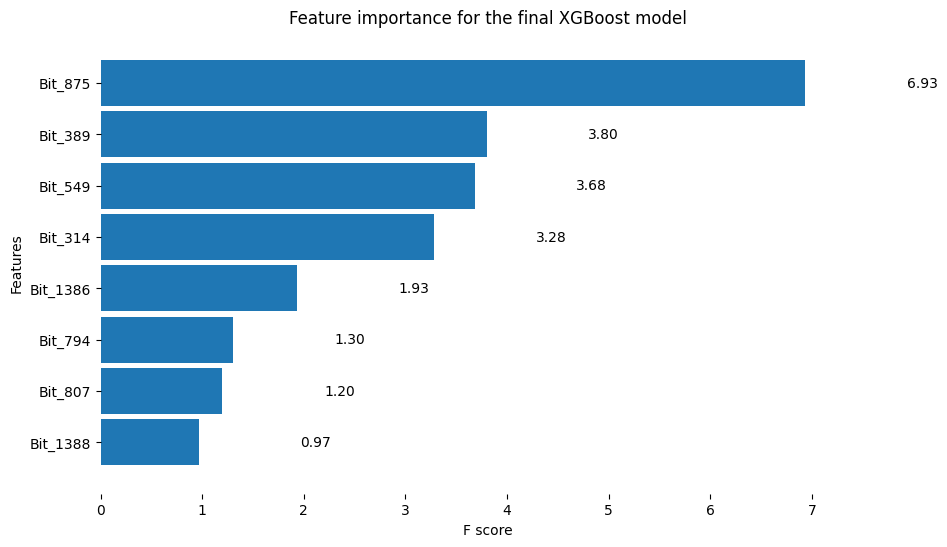

In [12]:
import xgboost as xgb
import matplotlib.pyplot as plt
import os

# Ensure the 'charts' directory exists
if not os.path.exists('charts'):
    os.makedirs('charts')

# Plotting feature importances using xgboost's built-in function
fig, ax = plt.subplots(figsize=(10, 6))
xgb.plot_importance(best_model, height=0.9, ax=ax, importance_type='gain', max_num_features=8, title='Feature importance for the final XGBoost model', show_values=True)

# Access the text elements and format them
for text in ax.texts:
    value = float(text.get_text())  # Extract current value
    text.set_text(f"{value:.2f}")  # Format and set new text value

ax.grid(False)  # Disable the grid
for spine in ax.spines.values():  # Correctly setting visibility to false
    spine.set_visible(False)

plt.savefig('charts/feature_importance_gain.png', dpi=300)  # Save the plot
plt.show()


#  ROC and the precision-recall curve for training data.

Features used for model training: ['Bit_314', 'Bit_389', 'Bit_549', 'Bit_794', 'Bit_807', 'Bit_875', 'Bit_1386', 'Bit_1388']
Features in X_train_selected: ['Bit_314', 'Bit_389', 'Bit_549', 'Bit_794', 'Bit_807', 'Bit_875', 'Bit_1386', 'Bit_1388']


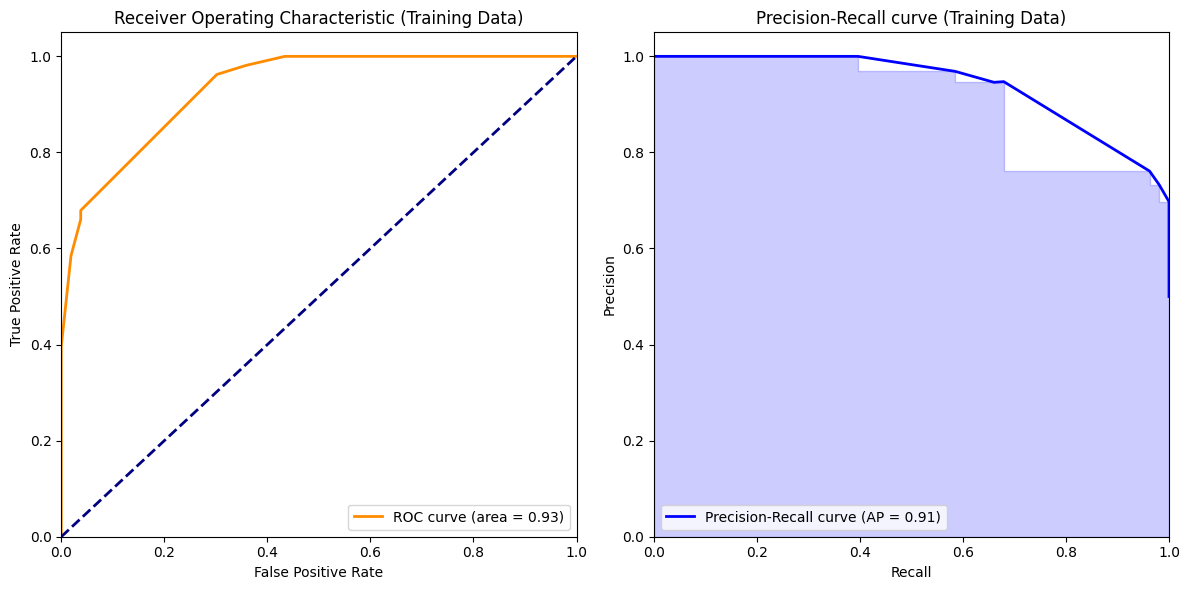

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import os


# Check if the feature names and order match the model's training features
print("Features used for model training:", best_model.get_booster().feature_names)
print("Features in X_train_selected:", X_train_selected.columns.tolist())

# Getting predicted probabilities for the positive class
y_scores_train = best_model.predict_proba(X_train_selected)[:, 1]

# Verify data consistency
if len(y_train_grid) == len(y_scores_train):
    # ROC Curve
    fpr_train, tpr_train, thresholds_roc = roc_curve(y_train_grid, y_scores_train)
    roc_auc_train = auc(fpr_train, tpr_train)
    
    # Precision-Recall Curve
    precision_train, recall_train, thresholds_pr = precision_recall_curve(y_train_grid, y_scores_train)
    average_precision_train = average_precision_score(y_train_grid, y_scores_train)
    
    # Plotting both ROC and Precision-Recall Curve
    plt.figure(figsize=(12, 6))

    # Subplot 1: ROC Curve
    plt.subplot(1, 2, 1)
    plt.plot(fpr_train, tpr_train, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_train)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (Training Data)')
    plt.legend(loc="lower right")

    # Subplot 2: Precision-Recall Curve
    plt.subplot(1, 2, 2)
    plt.plot(recall_train, precision_train, color='blue', lw=2, label='Precision-Recall curve (AP = %0.2f)' % average_precision_train)
    plt.fill_between(recall_train, precision_train, step='post', alpha=0.2, color='blue')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall curve (Training Data)')
    plt.legend(loc="lower left")

    plt.tight_layout()

    # Check if the directory exists
    output_directory = 'charts'
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    # Save the figure
    plt.savefig(f'{output_directory}/roc_precision_recall_training.png', dpi=300, bbox_inches='tight')

    # display the plot
    plt.show()
else:
    print("Mismatch in the number of training samples and predictions, cannot plot ROC or Precision-Recall curve.")


# Plotting the learning curve

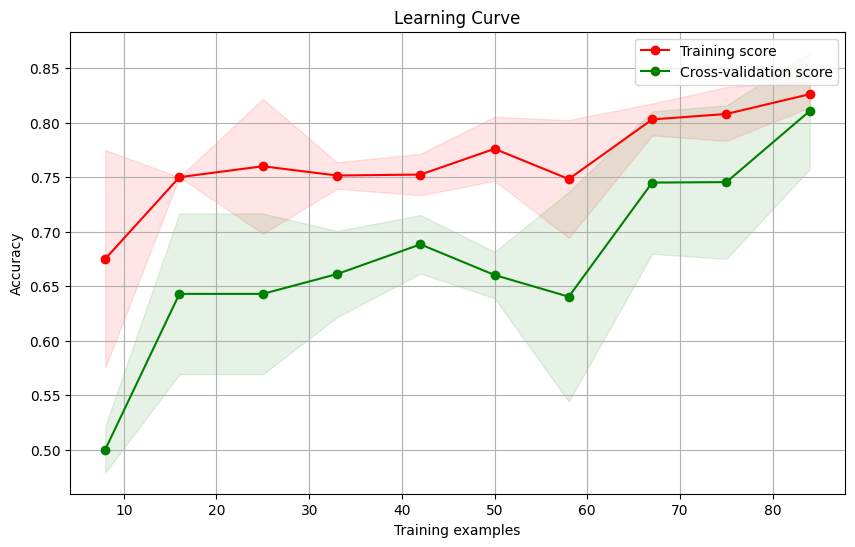

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve, StratifiedKFold
import os

# `new_best_model` and `X_train_selected` have been defined from the previous context

# Set up the parameters for the learning curve
train_sizes, train_scores, test_scores = learning_curve(
    estimator=best_model,  # Use the new best model from hyperparameter tuning
    X=X_train_selected,  # Ensure this uses the correct selected features
    y=y_train_grid,  # Training labels
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=StratifiedKFold(5),
    scoring='accuracy',
    n_jobs=-1
)

# Calculate mean and standard deviation for training and test set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training score")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="r")
plt.plot(train_sizes, test_mean, 'o-', color="g", label="Cross-validation score")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="g")

# Creating the plot
plt.title("Learning Curve")
plt.xlabel("Training examples")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.grid(True)

# Check if the directory exists and create it if it doesn't
output_directory = 'charts'
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Save the figure
plt.savefig(f'{output_directory}/learning_curve.png', dpi=300, bbox_inches='tight')
plt.show()


# Testing on unseen data

In [15]:
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef

# Transform the unseen data using the same selected features
X_test_unseen_selected = X_test_unseen.iloc[:, best_support]  # Use best_support from the initial feature selection

# Predict the unseen data using the new best estimator found from the adjusted grid search
y_pred_unseen = best_model.predict(X_test_unseen_selected)

# Evaluate the predictions
cm = confusion_matrix(y_test_unseen, y_pred_unseen)
tn, fp, fn, tp = cm.ravel()

# Calculate Sensitivity (Recall or True Positive Rate), Specificity, and Accuracy
sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0  # Handle division by zero for sensitivity
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0  # Handle division by zero for specificity
accuracy = accuracy_score(y_test_unseen, y_pred_unseen)

# Calculate Positive Predictive Value (PPV or Precision) and Negative Predictive Value (NPV)
precision = precision_score(y_test_unseen, y_pred_unseen, zero_division=0)  # Handle zero division for precision
npv = tn / (tn + fn) if (tn + fn) > 0 else 0  # Handle division by zero for NPV

# Calculate the Matthews Correlation Coefficient
mcc = matthews_corrcoef(y_test_unseen, y_pred_unseen)

# Calculate F1 Score
f1 = f1_score(y_test_unseen, y_pred_unseen)

# Printing results
print(f"Sensitivity (Recall or True Positive Rate): {sensitivity:.2f}")
print(f"Specificity (True Negative Rate): {specificity:.2f}")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision (Positive Predictive Value): {precision:.2f}")
print(f"Negative Predictive Value: {npv:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Matthews Correlation Coefficient: {mcc:.2f}")


Sensitivity (Recall or True Positive Rate): 0.83
Specificity (True Negative Rate): 0.71
Accuracy: 0.77
Precision (Positive Predictive Value): 0.75
Negative Predictive Value: 0.80
F1 Score: 0.79
Matthews Correlation Coefficient: 0.54


# ROC Curve, Precision-Recall Curve on unseen data


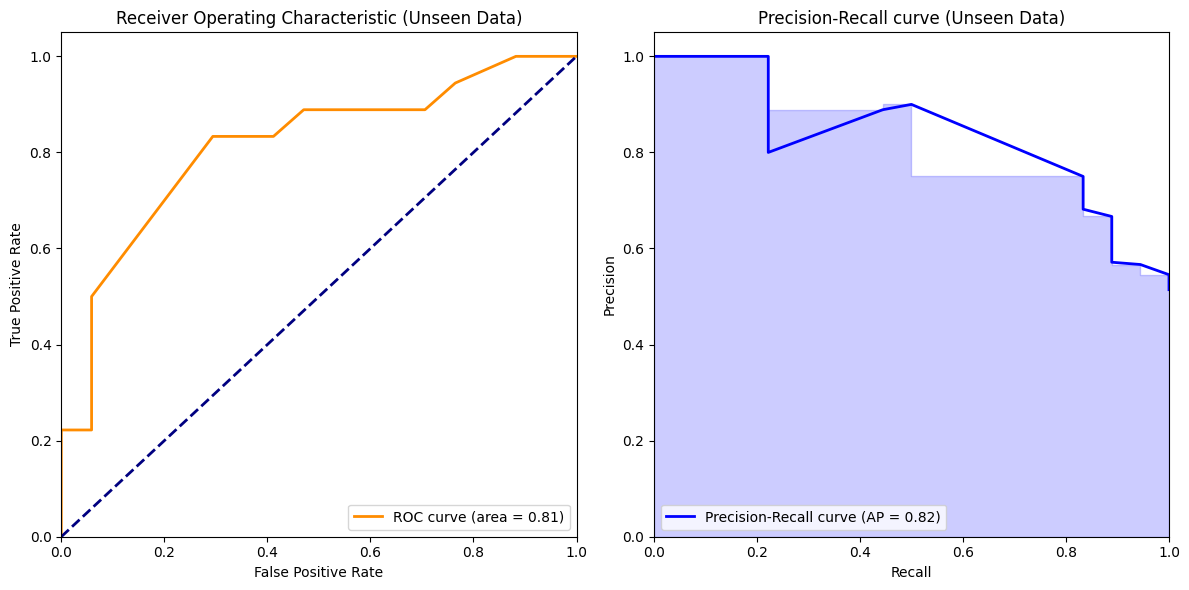

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import os

# Ensure the data is prepared similarly to the training phase
y_scores_unseen = best_model.predict_proba(X_test_unseen_selected)[:, 1]

# ROC Curve for unseen data
fpr_unseen, tpr_unseen, thresholds_roc_unseen = roc_curve(y_test_unseen, y_scores_unseen)
roc_auc_unseen = auc(fpr_unseen, tpr_unseen)

# Precision-Recall Curve for unseen data
precision_unseen, recall_unseen, thresholds_pr_unseen = precision_recall_curve(y_test_unseen, y_scores_unseen)
average_precision_unseen = average_precision_score(y_test_unseen, y_scores_unseen)

# Plotting both ROC and Precision-Recall Curve
plt.figure(figsize=(12, 6))

# Subplot 1: ROC Curve
plt.subplot(1, 2, 1)
plt.plot(fpr_unseen, tpr_unseen, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_unseen)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Unseen Data)')
plt.legend(loc="lower right")

# Subplot 2: Precision-Recall Curve
plt.subplot(1, 2, 2)
plt.plot(recall_unseen, precision_unseen, color='blue', lw=2, label='Precision-Recall curve (AP = %0.2f)' % average_precision_unseen)
plt.fill_between(recall_unseen, precision_unseen, step='post', alpha=0.2, color='blue')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve (Unseen Data)')
plt.legend(loc="lower left")

plt.tight_layout()

# Check if the directory exists
output_directory = 'charts'
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Save the figure
plt.savefig(f'{output_directory}/roc_precision_recall_unseen.png', dpi=300, bbox_inches='tight')

# display the plot
plt.show()


# Shap values for feature interaction plots

https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/Basic%20SHAP%20Interaction%20Value%20Example%20in%20XGBoost.html#

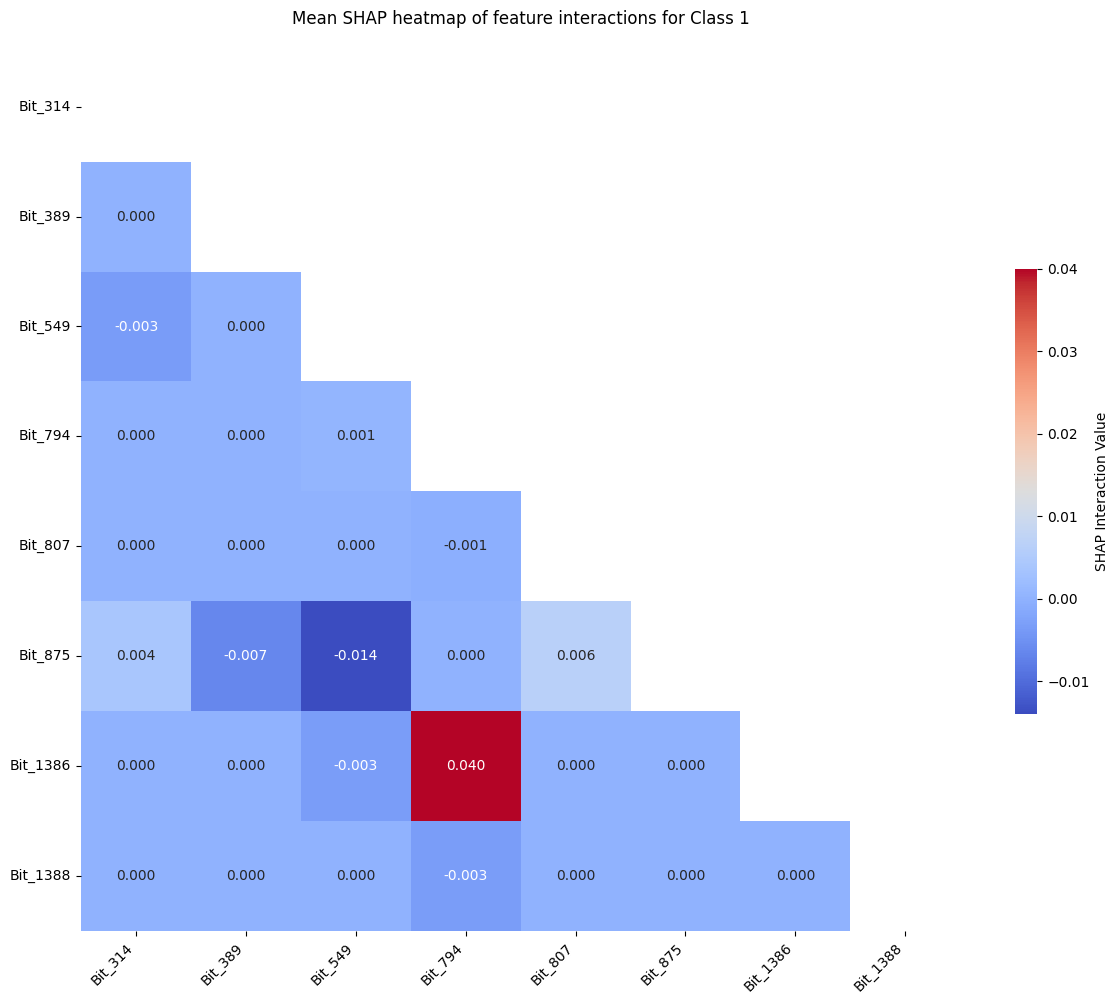

In [17]:
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load model and data
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_train_selected)

# Compute SHAP interaction values for the positive class (class 1)
if isinstance(shap_values, list):
    shap_interaction_values = explainer.shap_interaction_values(X_train_selected)[1]
else:
    shap_interaction_values = explainer.shap_interaction_values(X_train_selected)

# Aggregate interaction values across all samples (mean over the 0th axis)
mean_shap_interaction_values = np.mean(shap_interaction_values, axis=0)

# Mask the upper triangle and diagonal to focus only on interaction pairs
mask = np.triu(np.ones_like(mean_shap_interaction_values, dtype=bool))

# Set up a large figure for clearer visualization
plt.figure(figsize=(12, 10))

# Create the heatmap using seaborn
sns.heatmap(mean_shap_interaction_values, mask=mask, annot=True, cmap='coolwarm',
            cbar_kws={'shrink': 0.5, 'label': 'SHAP Interaction Value'},  # Customize colorbar
            square=True, fmt=".3f",  # Adjusted to format numbers to three decimal places
            xticklabels=X_train_selected.columns,
            yticklabels=X_train_selected.columns)

# Improve aesthetics
plt.title("Mean SHAP heatmap of feature interactions for Class 1", pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()  # Adjust the layout to make room for label rotations

# Save the figure with high resolution
plt.savefig('charts/mean_feature_interaction_heatmap_class_1.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()


# Inspecting Features

In [1486]:
import pandas as pd
import os

# Load the data
file_path = 'aggregated_plants.csv'
df = pd.read_csv(file_path)

# List of important features from the model 
important_features = [
    'Bit_875',
    'Bit_389',
    'Bit_549',
    'Bit_314',
    'Bit_794',
    'Bit_807',
    'Bit_1388',
    'Bit_1386',
]



save_dir = './features/' 

# Check if the directory exists, if not, create it
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Iterating through each important feature
for feature in important_features:
    # Filter rows where the feature is present (1)
    feature_present_df = df[df[feature] == 1]
    
    # Drop all other 'Bit_' columns except the one in focus
    columns_to_drop = [col for col in df.columns if col.startswith('Bit_') and col != feature]
    feature_present_df = feature_present_df.drop(columns=columns_to_drop)
    
    # Define the new file path
    new_file_path = save_dir + f"{feature}.csv"
    
    # Save the filtered rows to a new CSV file
    feature_present_df.to_csv(new_file_path, index=False)
    
    print(f"Rows where {feature} is present and all other Bit_ columns are removed have been saved to '{new_file_path}'")


Rows where Bit_875 is present and all other Bit_ columns are removed have been saved to './features/Bit_875.csv'
Rows where Bit_389 is present and all other Bit_ columns are removed have been saved to './features/Bit_389.csv'
Rows where Bit_549 is present and all other Bit_ columns are removed have been saved to './features/Bit_549.csv'
Rows where Bit_314 is present and all other Bit_ columns are removed have been saved to './features/Bit_314.csv'
Rows where Bit_794 is present and all other Bit_ columns are removed have been saved to './features/Bit_794.csv'
Rows where Bit_807 is present and all other Bit_ columns are removed have been saved to './features/Bit_807.csv'
Rows where Bit_1388 is present and all other Bit_ columns are removed have been saved to './features/Bit_1388.csv'
Rows where Bit_1386 is present and all other Bit_ columns are removed have been saved to './features/Bit_1386.csv'


# Adding SMILES-Chemical pairs, Chemical names, and Concentrations


In [1487]:
import pandas as pd
import os
import ast
from collections import Counter
import glob

def safe_literal_eval(s):
    dict_strings = [d.strip() for d in s.split(';') if d.strip()]
    all_dicts = {}
    for dict_str in dict_strings:
        try:
            all_dicts.update(ast.literal_eval(dict_str))
        except Exception as e:
            print(f"Failed to parse part: {dict_str}\nError: {e}")
    return all_dicts

def preprocess_bit_name(bit_name):
    bit_number = bit_name.replace('Bit_', '').replace('.csv', '')
    return int(bit_number)

features_dir = 'features/'
reorganized_plants_path = 'reorganized_plants_filtered.csv'
combined_chemicals_path = '../initial_data/combined_chemicals_smiles.csv'

reorganized_plants_df = pd.read_csv(reorganized_plants_path)
combined_chemicals_df = pd.read_csv(combined_chemicals_path)  # Load the combined chemicals data
reorganized_plants_df = reorganized_plants_df.drop_duplicates(subset=['Plant_Species', 'Chemical'])

assert 'Concentration' in reorganized_plants_df.columns, "Concentration column not found in the reorganized plants data!"

bit_files = glob.glob(os.path.join(features_dir, 'Bit_*.csv'))

for bit_file in bit_files:
    bit_name = os.path.basename(bit_file)
    bit_name = bit_name.replace('.csv', '')

    new_bit_file = os.path.join(features_dir, f"{bit_name}_updated.csv")

    bit_df = pd.read_csv(bit_file)

    bit_df['BitInterpretations'] = bit_df['BitInterpretations'].apply(safe_literal_eval)

    if 'SMILES' not in bit_df.columns:
        bit_df.insert(3, 'SMILES', '')
    if 'Chemical' not in bit_df.columns:
        bit_df.insert(4, 'Chemical', '')
    if 'Chemical_name' not in bit_df.columns:  # Add Chemical_name column 
        bit_df.insert(5, 'Chemical_name', '')

    expanded_rows = []

    for index, row in bit_df.iterrows():
        plant_species = row['Plant_Species']
        bit_interpretations = row['BitInterpretations']
        bit_number = preprocess_bit_name(bit_name)

        if bit_number in bit_interpretations:
            interpreted_bit = str(bit_interpretations[bit_number])
        else:
            interpreted_bit = ''

        matching_rows = reorganized_plants_df[
            (reorganized_plants_df['Plant_Species'].str.lower() == plant_species.lower()) &
            (reorganized_plants_df[bit_name] == 1)]

        for _, match in matching_rows.iterrows():
            new_row = row.copy()
            new_row['SMILES'] = match['SMILES']
            new_row['Chemical'] = match['Chemical']
            new_row['BitInterpretations'] = interpreted_bit
            new_row['Chemical_name'] = combined_chemicals_df[combined_chemicals_df['SMILES'] == match['SMILES']]['Chemical Name'].iloc[0]

            # Ensure matching both 'SMILES' and 'Plant_Species'
            concentration_match = reorganized_plants_df[
                (reorganized_plants_df['SMILES'] == match['SMILES']) & 
                (reorganized_plants_df['Plant_Species'].str.lower() == plant_species.lower())
            ]['Concentration']

            new_row['Concentration'] = concentration_match.iloc[0] if not concentration_match.empty else None

            expanded_rows.append(new_row)

    expanded_bit_df = pd.DataFrame(expanded_rows)

    # Remove the 'Chemical' column as it's no longer needed
    expanded_bit_df = expanded_bit_df.drop(columns=['Chemical'])

    expanded_bit_df = expanded_bit_df.sort_values(by='Chemical_name', ascending=True)

    expanded_bit_df.to_csv(new_bit_file, index=False)

    print(f"Updated {bit_name} with individual SMILES, Chemical names from combined file has been saved to {new_bit_file}")

print("All Bit files have been processed and updated with individual SMILES-Chemical pairs, Chemical names, and Concentrations.")


Updated Bit_794 with individual SMILES, Chemical names from combined file has been saved to features/Bit_794_updated.csv
Updated Bit_807 with individual SMILES, Chemical names from combined file has been saved to features/Bit_807_updated.csv
Updated Bit_875 with individual SMILES, Chemical names from combined file has been saved to features/Bit_875_updated.csv
Updated Bit_1388 with individual SMILES, Chemical names from combined file has been saved to features/Bit_1388_updated.csv
Updated Bit_1386 with individual SMILES, Chemical names from combined file has been saved to features/Bit_1386_updated.csv
Updated Bit_314 with individual SMILES, Chemical names from combined file has been saved to features/Bit_314_updated.csv
Updated Bit_389 with individual SMILES, Chemical names from combined file has been saved to features/Bit_389_updated.csv
Updated Bit_549 with individual SMILES, Chemical names from combined file has been saved to features/Bit_549_updated.csv
All Bit files have been proc

# Remove all rare chemicals which appear only once (not interesting for the domain)

In [1567]:
import pandas as pd
import os
import glob

features_dir = 'features/'

# Gather all updated CSV files
updated_files = glob.glob(os.path.join(features_dir, '*_updated.csv'))

# Process each CSV file independently
for file in updated_files:
    df = pd.read_csv(file)
    # Count the occurrences of each chemical name in this specific file
    chemical_name_counts = df['Chemical_name'].value_counts()
    # Identify chemical names that appear more than once
    chemicals_to_keep = chemical_name_counts[chemical_name_counts > 1].index
    
    # Filter the dataframe to only include rows with chemical names that appear more than once
    filtered_df = df[df['Chemical_name'].isin(chemicals_to_keep)]
    
    # Save the filtered dataframe back to the same CSV file
    filtered_df.to_csv(file, index=False)
    print(f"Filtered data saved back to {file}")

print("All updated CSV files have been re-processed to exclude unique chemical names.")


Filtered data saved back to features/Bit_389_updated.csv
Filtered data saved back to features/Bit_875_updated.csv
Filtered data saved back to features/Bit_314_updated.csv
Filtered data saved back to features/Bit_1388_updated.csv
Filtered data saved back to features/Bit_549_updated.csv
Filtered data saved back to features/Bit_1386_updated.csv
Filtered data saved back to features/Bit_794_updated.csv
Filtered data saved back to features/Bit_807_updated.csv
All updated CSV files have been re-processed to exclude unique chemical names.


# Visualisation of molecular features

In [1579]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors, Draw
import os

important_features = [
    'Bit_875',
    'Bit_389',
    'Bit_549',
    'Bit_314',
    'Bit_794',
    'Bit_807',
    'Bit_1388',
    'Bit_1386'
]

# Define the output folder for SVG images
output_folder = 'visualizations'  # Adjust as needed
os.makedirs(output_folder, exist_ok=True)  # Create the folder if it doesn't exist

for feature in important_features:
    bit_number = feature.split('_')[1]  # Extract the bit number from the feature name
    updated_file_path = f'features/{feature}_updated.csv'  # Construct the file path dynamically
    
    try:
        df = pd.read_csv(updated_file_path)
    except FileNotFoundError:
        print(f"File {updated_file_path} not found, skipping.")
        continue

    bit_to_visualize = int(bit_number)  # Convert the bit number to an integer

    for idx, row in df.drop_duplicates(subset='SMILES').iterrows():
        smiles = row['SMILES']
        chemical_name = row.get('Chemical_name', 'Unnamed_Chemical')  # Default name if not present
        plant_species = row.get('Plant_Species', 'UnknownSpecies').split()[:2]  # Get first two words of plant species
        concentration = row.get('Concentration', 0)  # Get concentration value, default to 0 if not present

        # Generate a molecule from the SMILES string
        mol = Chem.MolFromSmiles(smiles)
        if not mol: continue  # Skip if molecule can't be created

        # Generate a Morgan fingerprint and save information about the bits that are set
        bit_info = {}
        fp = rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048, bitInfo=bit_info)

        if bit_to_visualize in bit_info:
            # Visualize the first example of the bit setting
            whichExample = 0  # Always use the first example
            img = Draw.DrawMorganBit(mol, bit_to_visualize, bit_info, whichExample=whichExample, useSVG=True)
            
            # Ensure the chemical name, plant species, and concentration are filesystem safe
            safe_chemical_name = ''.join(e for e in chemical_name if e.isalnum())
            safe_plant_species = '_'.join(''.join(e for e in word if e.isalnum()) for word in plant_species)
            safe_concentration = ''.join(e for e in str(concentration) if e.isdigit() or e == '.')  # Convert float to string

            # Filename includes the bit, chemical name, plant species, and concentration
            svg_file_path = os.path.join(output_folder, f"bit_{bit_to_visualize}_{safe_chemical_name}_{safe_plant_species}_conc_{safe_concentration}.svg")
            with open(svg_file_path, "w") as svg_file:
                svg_file.write(img.data)
            print(f"Saved SVG image to {svg_file_path}")


Saved SVG image to visualizations/bit_875_Carvacrol_Artemisia_chamaemelifolia_conc_0.163.svg
Saved SVG image to visualizations/bit_875_Eugenol_Artemisia_scoparia_conc_0.3.svg
Saved SVG image to visualizations/bit_875_Eugenylacetate_Eugenia_caryophyllus_conc_0.205.svg
Saved SVG image to visualizations/bit_875_Thymol_Oliveria_decumbens_conc_0.372.svg
Saved SVG image to visualizations/bit_389_2Phenylethanol_Mimusops_elengi_conc_0.378.svg
Saved SVG image to visualizations/bit_389_Hexadecanoicacid_Catharanthus_roseus_conc_0.649.svg
Saved SVG image to visualizations/bit_389_Linolenicacid_Spartium_junceum_conc_0.09.svg
Saved SVG image to visualizations/bit_389_Methylbenzoate_Mimusops_elengi_conc_0.134.svg
Saved SVG image to visualizations/bit_549_Bicyclogermacrene_Neolitsea_brassii_conc_0.126.svg
Saved SVG image to visualizations/bit_549_alphaPinene_Cupressocyparis_leylandii_conc_0.1.svg
Saved SVG image to visualizations/bit_549_betaPinene_Piper_nigrum_conc_0.0963.svg
Saved SVG image to visua

# Get the names of the chemicals contatinig the feature

In [1578]:
import pandas as pd

# Load the CSV file into a DataFrame
df = pd.read_csv('features/Bit_1388_updated.csv')

# Ensure that the column you're interested in is named 'Chemical name'
# Convert all names in 'Chemical name' to lowercase
lowercase_names = df['Chemical_name'].str.lower()

# Get unique names
unique_names = lowercase_names.unique()

# Join the unique names into a comma-separated string
names_string = ', '.join(unique_names)

# Print the result
print(names_string)


(+)-alpha-terpineol
